In [146]:
import numpy as np
import shutil
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pickle
from math import sin,cos
import math

In [2]:
root = '/Users/guoqiushi/Documents/thesis/indoor_final/'

In [3]:
class fileObject:
    
    def __init__(self,root,index):
        self.root = root
        self.index = index
        self.path = os.path.join(root,str(index))
        for files in os.listdir(self.path):
            if files.startswith('IMU'):
                self.imu_path = os.path.join(self.path,files)
            elif files.startswith('Mag'):
                self.mag_path = os.path.join(self.path,files)
            elif files.startswith('ultra'):
                self.ultra_path = os.path.join(self.path,files)
        self.height_dict = {
            '1': 0.736,
            '2': 0.782,
            '3': 0.827,
            '4': 0.877,
            '5': 0.936,
            '6': 0.981,
            '7': 1.043,
            '8': 1.102,
            '9': 1.10
        }
                
    def get_ultra(self):
        Dataframe = pd.read_csv(self.ultra_path, sep=" ", names=["ID", "P_x", "P_y", "P_z", "unknow", "unknow_1", "Time_Stamp"])
        Dataframe = Dataframe.drop(["ID", "unknow", "unknow_1"], axis=1)
        rows, columns = Dataframe.shape
        serial_num = np.arange(0, rows, 1).tolist()
        serial_num_inte = np.arange(0, rows, 0.1).tolist()
        Px_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_x"])
        Py_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_y"])
        Pz_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_z"])
        Pt_inte = np.interp(serial_num_inte, serial_num, Dataframe["Time_Stamp"])
        Dataframe_inte = pd.DataFrame(columns=["Serial_Num", 'P_X', 'P_Y', 'P_Z', "Time_Stamp"])
        Dataframe_inte["Serial_Num"] = np.arange(0, len(serial_num_inte), 1).tolist()
        Dataframe_inte["P_X"] = Px_inte
        Dataframe_inte["P_Y"] = Py_inte
        Dataframe_inte['P_Z'] = self.height_dict[str(self.index)]
        #Dataframe_inte["P_Z"] = Pz_inte
        Dataframe_inte["Time_Stamp"] = Pt_inte
        return Dataframe_inte
    
    def get_mag(self):
        df_tem = pd.read_csv(self.mag_path,sep=" ",names=["Serial_Num", "R_x", "R_y", "R_z", "Time_Stamp"],index_col="Serial_Num")
        df_tem["Magnitude"] = np.sqrt(
                np.power(df_tem["R_x"], 2) + np.power(df_tem["R_y"], 2) + np.power(df_tem["R_z"], 2))
        return df_tem
    
    def get_imu(self):
        df_tem = pd.read_csv(self.imu_path,sep=" ",
                    names=['a_x','a_y','a_z','G_x','G_y','G_z','M_x','M_y','M_z','alpha','beta','gama','mill','Time_Stamp','index'],
                    index_col="index")
        return df_tem
    
    def get_IMU_info(self,time_mag,df_imu):
        time_imu = df_imu['Time_Stamp'].to_numpy()
        sub_array = abs(time_imu-time_mag)
        index = np.argmin(sub_array)
        alpha,beta,gama = df_imu.iloc[index,9],df_imu.iloc[index,10],df_imu.iloc[index,11]
        a_x,a_y,a_z = df_imu.iloc[index,0],df_imu.iloc[index,1],df_imu.iloc[index,2]
        return a_x,a_y,a_z,alpha,beta,gama
        
    def get_position(self,time_mag,df_ultra):
        time_ultra = df_ultra['Time_Stamp'].to_numpy()
        sub_array = abs(time_ultra-time_mag)
        index = np.argmin(sub_array)
        p_x,p_y,p_z = df_ultra.iloc[index,1],df_ultra.iloc[index,2],df_ultra.iloc[index,3]
        #print(p_x,p_y,p_z)
        return p_x,p_y,p_z
    
    def merge_all(self):
        df_mag = self.get_mag()
        df_ultra = self.get_ultra()
        df_imu = self.get_imu()
        position = []
        imu_data = []
        for i in range(df_mag.shape[0]):
            position.append(self.get_position(df_mag.iloc[i,3],df_ultra))
            imu_data.append(self.get_IMU_info(df_mag.iloc[i,3],df_imu))
        position_array = np.array(position)
        imu_data_array = np.array(imu_data)  
        df_mag['p_x'] = position_array[:,0]
        df_mag['p_y'] = position_array[:,1]
        df_mag['p_z'] = position_array[:,2]
        df_mag['d_t1'] = np.sqrt(np.power(position_array[:,0]-1.90,2)+np.power(position_array[:,1]-0.17,2)+np.power(position_array[:,2]-1.24,2))
        df_mag['d_t2'] = np.sqrt(np.power(position_array[:,0]-5.00,2)+np.power(position_array[:,1]-0.33,2)+np.power(position_array[:,2]-1.24,2))
        df_mag['d_t3'] = np.sqrt(np.power(position_array[:,0]-3.23,2)+np.power(position_array[:,1]+2.94,2)+np.power(position_array[:,2]-1.24,2))
        df_mag['a_x'] = imu_data_array[:,0]
        df_mag['a_y'] = imu_data_array[:,1]
        df_mag['a_z'] = imu_data_array[:,2]
        df_mag['alpha'] = imu_data_array[:,3]
        df_mag['beta'] = imu_data_array[:,4]
        df_mag['gama'] = imu_data_array[:,5]
        return df_mag
    
    def get_T_index(self, noise_threshould):
        df_mag_merge = self.merge_all()
        mag_array  = np.array(df_mag_merge['Magnitude'].tolist())
        mag_index = []
        for rows in range(10, df_mag_merge.shape[0] - 100):
            if np.sum(mag_array[rows - 1:rows + 4]) < np.sum(mag_array[rows:rows + 5]) and np.sum(
                    mag_array[rows + 1:rows + 6]) < np.sum(mag_array[rows:rows + 5]) and np.min(
                mag_array[rows:rows + 5]) > noise_threshould:  #### outdoor: 6800000
                mag_index.append(rows)
        T1_start = []
        T2_start = []
        T3_start = []

        for index in range(len(mag_index) - 3):
            if 7 < mag_index[index + 2] - mag_index[index + 1] < 11 and 7 < mag_index[index + 1] - mag_index[
                index] < 11:
                T1_start.append(mag_index[index])


            elif 10 < mag_index[index + 2] - mag_index[index + 1] < 14 and 7 < mag_index[index + 1] - mag_index[
                index] < 11:
                T2_start.append(mag_index[index])

            elif 7 < mag_index[index + 2] - mag_index[index + 1] < 11 and 10 < mag_index[index + 1] - mag_index[
                index] < 14:
                T3_start.append(mag_index[index])

        return T1_start,T2_start,T3_start

In [6]:
model_1 = fileObject(root,1)
model_2 = fileObject(root,2)
model_3 = fileObject(root,3)

In [22]:
model1_t1,model1_t2,model1_t3 = model_1.get_T_index(8000000)
model2_t1,model2_t2,model2_t3 = model_2.get_T_index(8000000)
model3_t1,model3_t2,model3_t3 = model_3.get_T_index(8000000)

In [9]:
df_merge_1 = model_1.merge_all()
df_merge_2 = model_2.merge_all()
df_merge_3 = model_3.merge_all()

In [13]:
mag_1_T1 = [max(df_merge_1.iloc[x:x+5,4]) for x in model1_t1]
dis_1_T1 = [df_merge_1.iloc[x,8] for x in model1_t1]
mag_2_T1 = [max(df_merge_2.iloc[x:x+5,4]) for x in model2_t1]
dis_2_T1 = [df_merge_2.iloc[x,8] for x in model2_t1]
mag_3_T1 = [max(df_merge_3.iloc[x:x+5,4]) for x in model3_t1]
dis_3_T1 = [df_merge_3.iloc[x,8] for x in model3_t1]

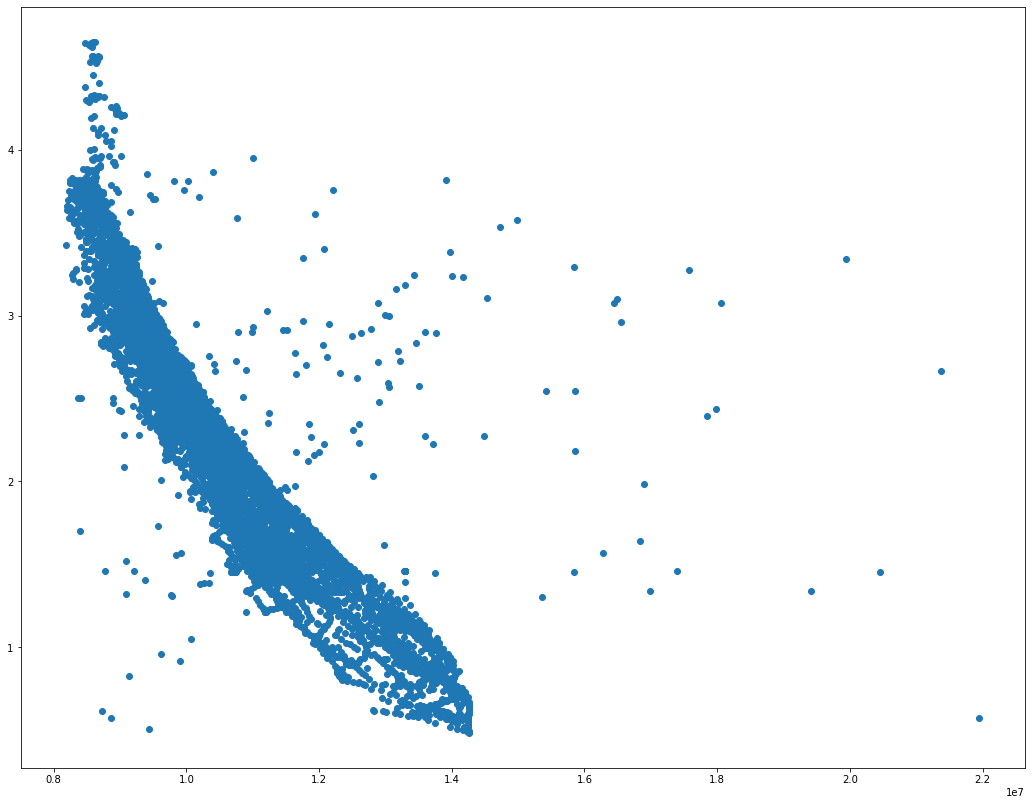

In [16]:
dis_1 =  dis_1_T1+dis_2_T1+dis_3_T1
mag_1 =  mag_1_T1+mag_2_T1+mag_3_T1
plt.figure(figsize=(18,14))
plt.scatter(mag_1,dis_1)
plt.show()

In [19]:
filter_t1 = []
for i in range(len(mag_1)):
    if mag_1[i]<8000000 or mag_1[i]>15000000:
        continue
    elif mag_1[i]>10800000 and dis_1[i]>2.5:
        continue
    else:
        filter_t1.append((mag_1[i],dis_1[i]))
filter_t1 = np.array(filter_t1)

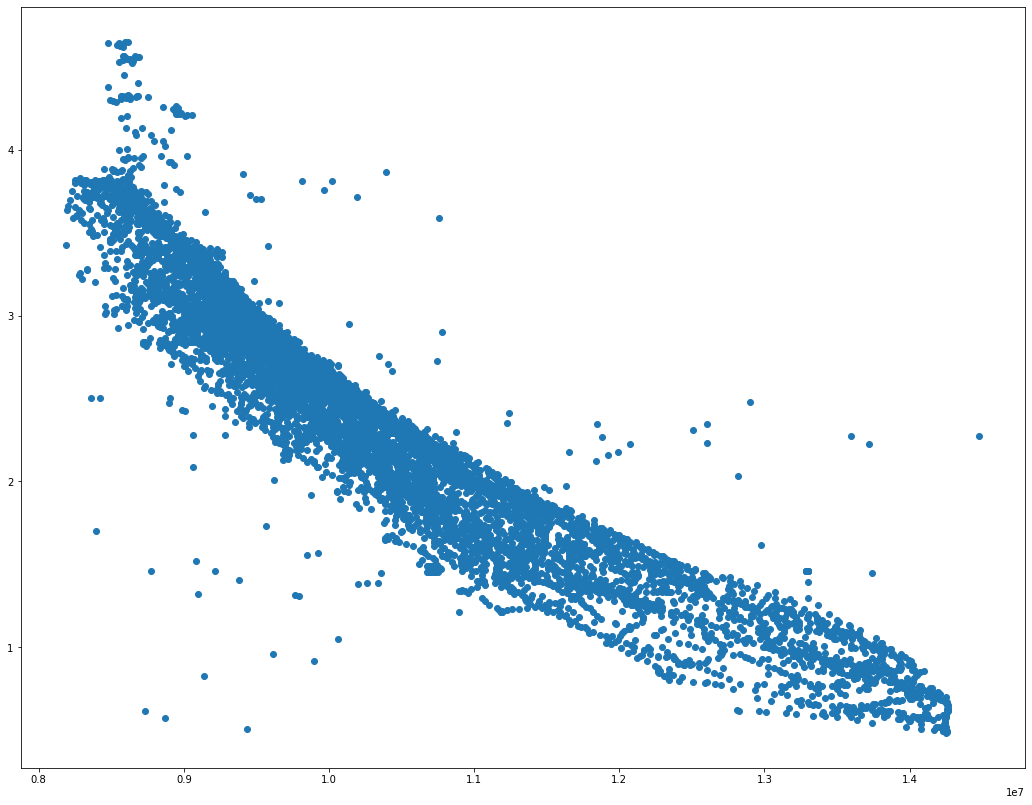

In [20]:
dis_1 =  dis_1_T1+dis_2_T1+dis_3_T1
mag_1 =  mag_1_T1+mag_2_T1+mag_3_T1
plt.figure(figsize=(18,14))
plt.scatter(filter_t1[:,0],filter_t1[:,1])
plt.show()

In [33]:
mag_1_T2 = [max(df_merge_1.iloc[x+40:x+45,4]) for x in model1_t1]
dis_1_T2 = [df_merge_1.iloc[x,9] for x in model1_t1]
mag_2_T2 = [max(df_merge_2.iloc[x+40:x+45,4]) for x in model2_t1]
dis_2_T2 = [df_merge_2.iloc[x,9] for x in model2_t1]
mag_3_T2 = [max(df_merge_3.iloc[x+40:x+45,4]) for x in model3_t1]
dis_3_T2 = [df_merge_3.iloc[x,9] for x in model3_t1]
dis_2 =  dis_1_T2+dis_2_T2+dis_3_T2
mag_2 =  mag_1_T2+mag_2_T2+mag_3_T2

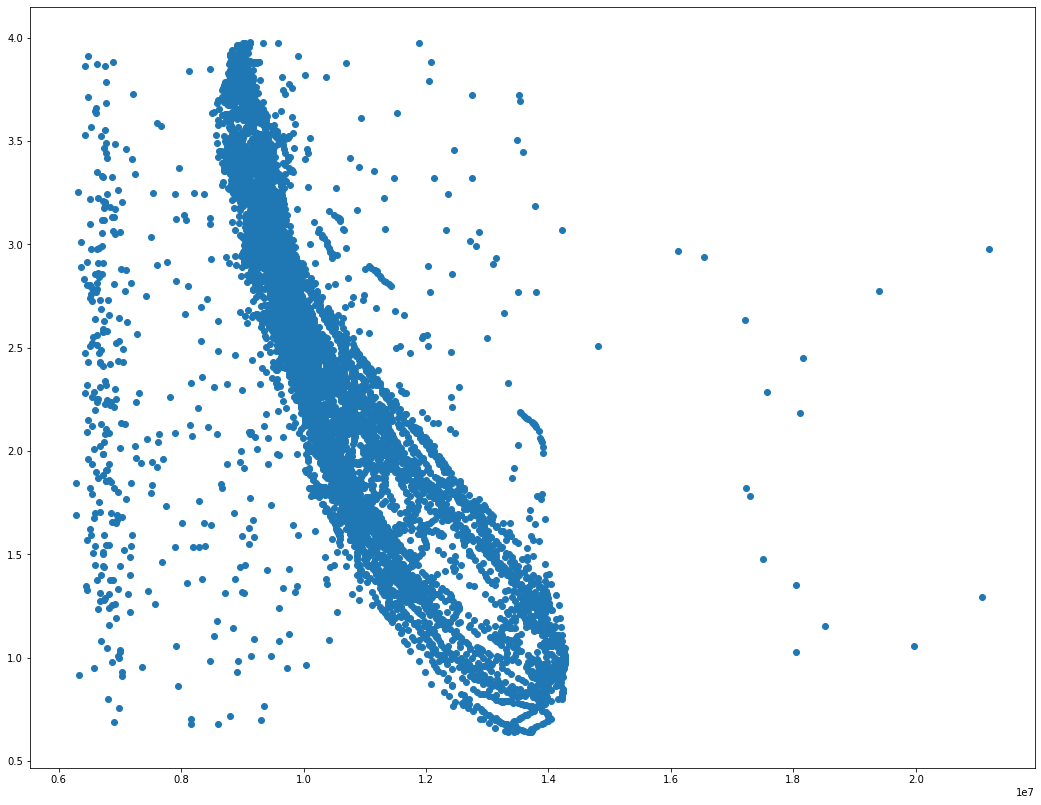

In [34]:
plt.figure(figsize=(18,14))
plt.scatter(mag_2,dis_2)
plt.show()

In [35]:
filter_t2 = []
for i in range(len(mag_2)):
    if mag_2[i]<8500000 or mag_2[i]>15000000:
        continue
    elif mag_2[i]>10800000 and dis_2[i]>2.3:
        continue
    elif mag_2[i]<9700000 and dis_2[i]<2.2:
        continue
    else:
        filter_t2.append((mag_2[i],dis_2[i]))
filter_t2 = np.array(filter_t2)

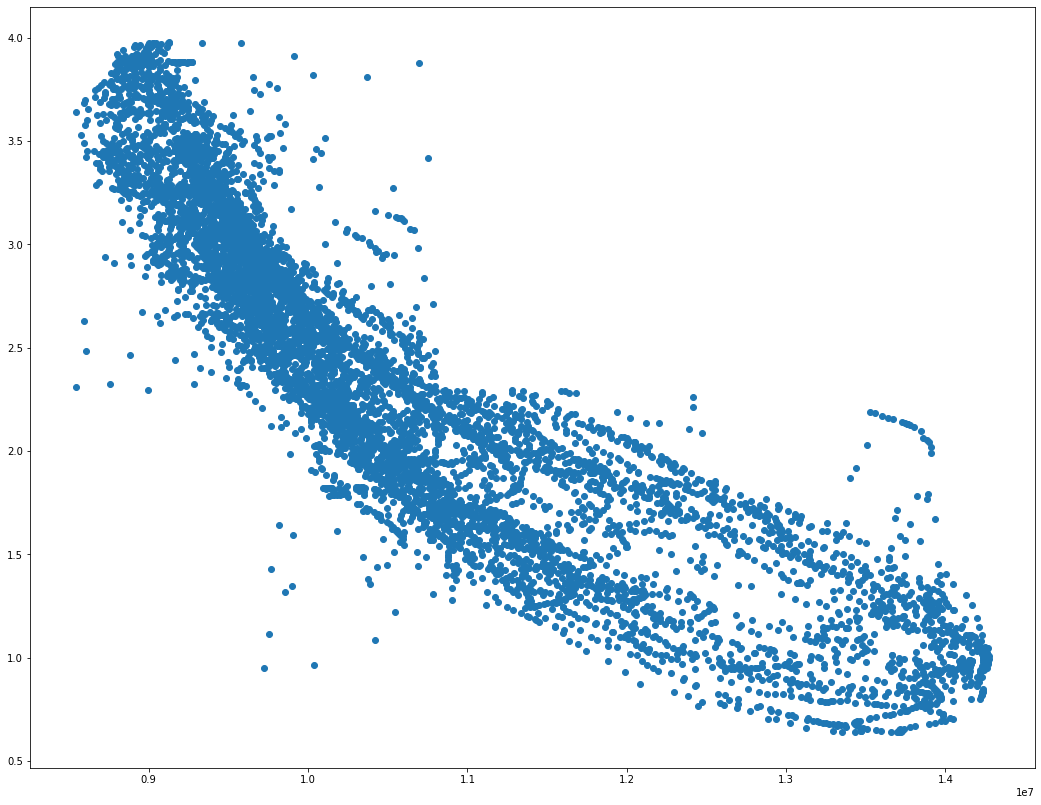

In [36]:
plt.figure(figsize=(18,14))
plt.scatter(filter_t2[:,0],filter_t2[:,1])
plt.show()

In [27]:
mag_1_T3 = [max(df_merge_1.iloc[x+80:x+85,4]) for x in model1_t1]
dis_1_T3 = [df_merge_1.iloc[x,10] for x in model1_t1]
mag_2_T3 = [max(df_merge_2.iloc[x+80:x+85,4]) for x in model2_t1]
dis_2_T3 = [df_merge_2.iloc[x,10] for x in model2_t1]
mag_3_T3 = [max(df_merge_3.iloc[x+80:x+85,4]) for x in model3_t1]
dis_3_T3 = [df_merge_3.iloc[x,10] for x in model3_t1]
dis_3 =  dis_1_T3+dis_2_T3+dis_3_T3
mag_3 =  mag_1_T3+mag_2_T3+mag_3_T3

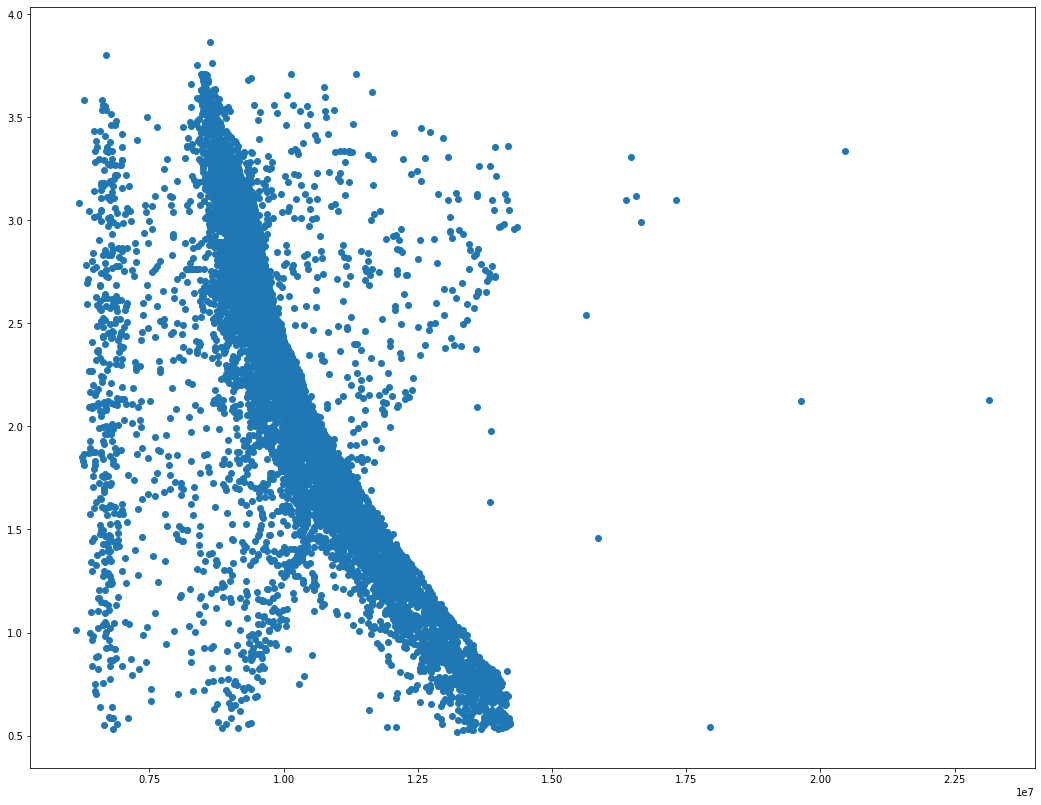

In [28]:
plt.figure(figsize=(18,14))
plt.scatter(mag_3,dis_3)
plt.show()

In [29]:
filter_t3 = []
for i in range(len(mag_3)):
    if mag_3[i]<8500000 or mag_3[i]>15000000:
        continue
    elif mag_3[i]>10800000 and dis_3[i]>2.2:
        continue
    elif mag_3[i]<10500000 and dis_3[i]<1.5:
        continue
    elif mag_3[i]<9300000 and dis_3[i]<2.3:
        continue
    else:
        filter_t3.append((mag_3[i],dis_3[i]))
filter_t3 = np.array(filter_t3)

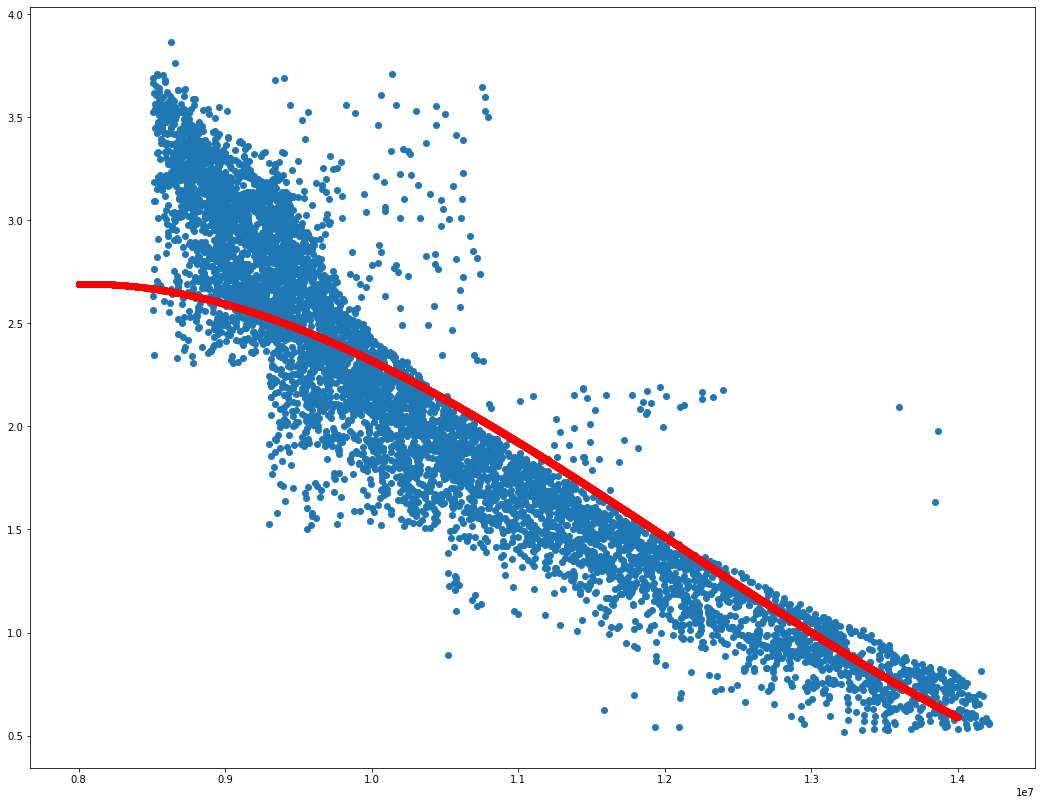

In [41]:
plt.figure(figsize=(18,14))
plt.scatter(filter_t3[:,0],filter_t3[:,1])
plt.scatter(x_test_3,y_test_3,color='red')
plt.show()

In [46]:
def PolynomialRegression(degree):
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("std_scaler", StandardScaler()),
        ("lin_reg", LinearRegression())
    ])


In [47]:
reg_1 = PolynomialRegression(degree=3)
reg_1.fit(filter_t1[:,0].reshape(-1,1), filter_t1[:,1])
reg_2 = PolynomialRegression(degree=3)
reg_2.fit(filter_t2[:,0].reshape(-1,1), filter_t2[:,1])
reg_3 = PolynomialRegression(degree=3)
reg_3.fit(filter_t3[:,0].reshape(-1,1), filter_t3[:,1])

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [58]:
joblib.dump(reg_3, '/Users/guoqiushi/PycharmProjects/Mag_thesis/model/reg_t3.model')
joblib.dump(reg_2, '/Users/guoqiushi/PycharmProjects/Mag_thesis/model/reg_t2.model')
joblib.dump(reg_1, '/Users/guoqiushi/PycharmProjects/Mag_thesis/model/reg_t1.model')

['/Users/guoqiushi/PycharmProjects/Mag_thesis/model/reg_t1.model']

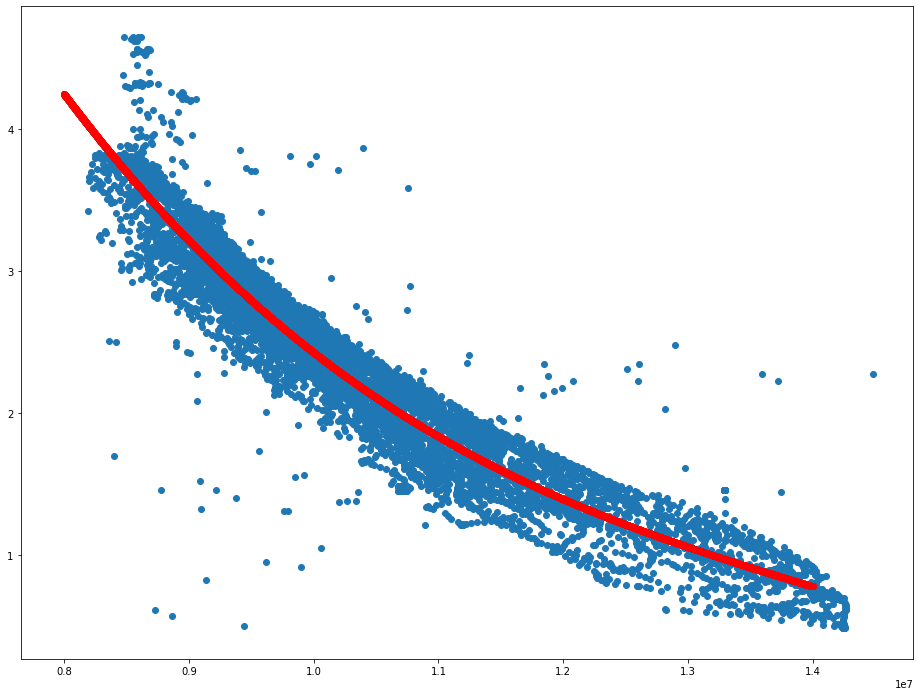

In [526]:
x_test_1 = np.arange(8000000,14000000,1000).reshape(-1,1)
y_test_1 = reg_1.predict(x_test_1)
plt.figure(figsize=(16,12))
plt.scatter(filter_t1[:,0],filter_t1[:,1])
plt.scatter(x_test_1,y_test_1,color='red')
plt.savefig("/Users/guoqiushi/PycharmProjects/Mag_thesis/figure/1_reg.png")
plt.show()


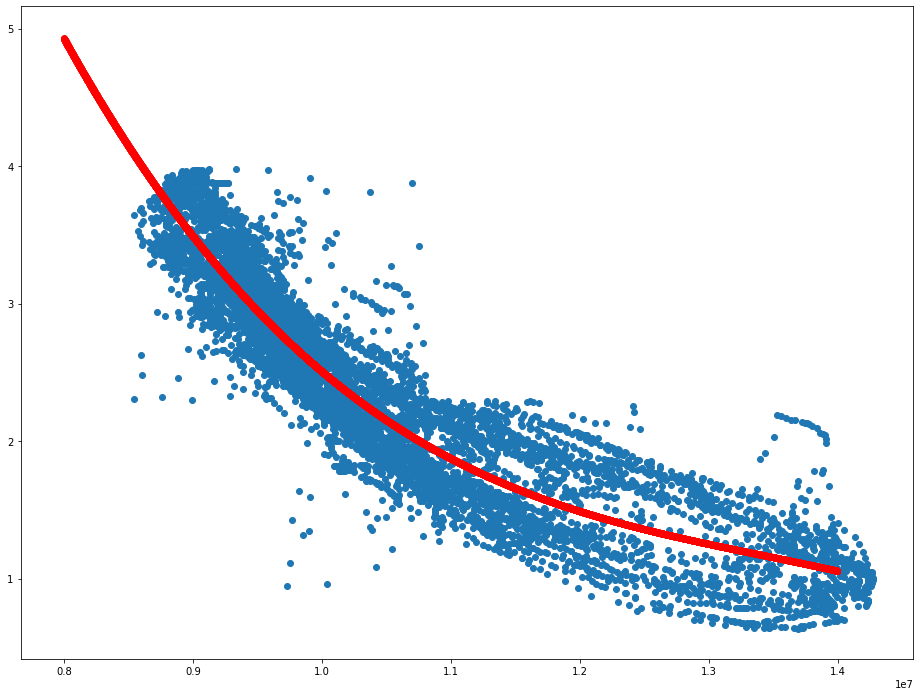

In [527]:
x_test_2 = np.arange(8000000,14000000,1000).reshape(-1,1)
y_test_2 = reg_2.predict(x_test_1)
plt.figure(figsize=(16,12))
plt.scatter(filter_t2[:,0],filter_t2[:,1])
plt.scatter(x_test_2,y_test_2,color='red')
plt.savefig("/Users/guoqiushi/PycharmProjects/Mag_thesis/figure/2_reg.png")
plt.show()

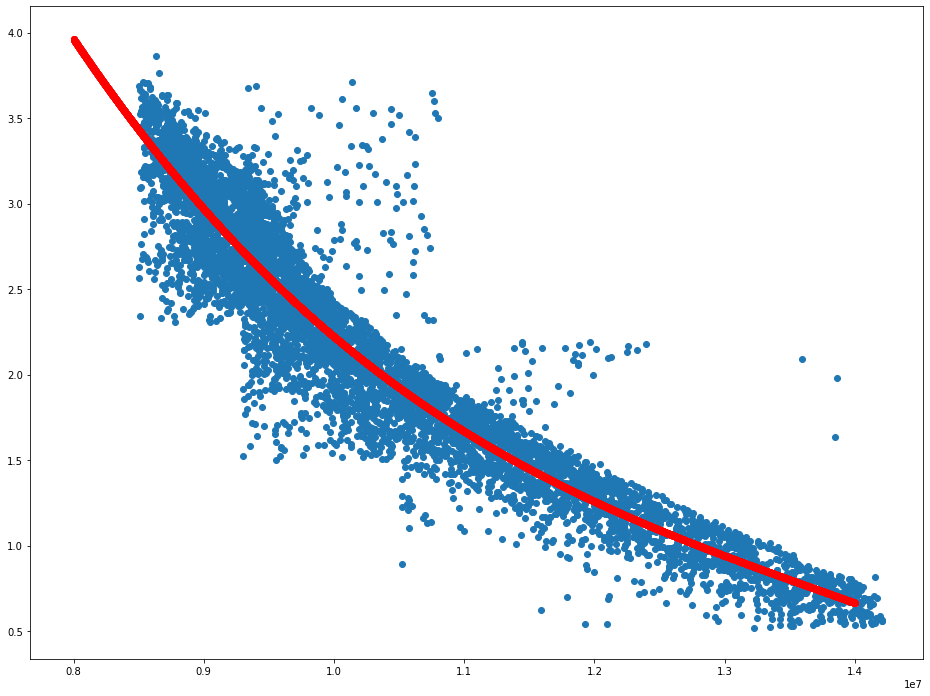

In [525]:
x_test_3 = np.arange(8000000,14000000,1000).reshape(-1,1)
y_test_3 = reg_3.predict(x_test_3)
plt.figure(figsize=(16,12))
plt.scatter(filter_t3[:,0],filter_t3[:,1])
plt.scatter(x_test_3,y_test_3,color='red')
plt.savefig("/Users/guoqiushi/Documents/3_reg.png")
plt.show()


In [126]:
def predict_phy(mag_x,mag_y,mag_z):
    
    D_t1 = reg_1.predict([[mag_x]])
    D_t2 = reg_2.predict([[mag_y]])
    D_t3 = reg_3.predict([[mag_z]])
    x_min, x_max = 1.698, 5.709
    y_min, y_max = -2.957,0.553
    z_min, z_max = 0.736,1.10
    
    x_list = list(np.arange(x_min,x_max,0.05))
    y_list = list(np.arange(y_min,y_max,0.05))
    z_list = list(np.arange(z_min,z_max,0.05))
    
    result = []
    for x_i in x_list:
        for y_i in y_list:
            for z_i in z_list:
                d_t1,d_t2,d_t3 = cal_dis(x_i,y_i,z_i)
                if abs(d_t1-D_t1)<0.4 and abs(d_t2-D_t2)<0.4 and abs(d_t3-D_t3)<0.4:
                    sum_dis = abs(d_t1-D_t1)+abs(d_t2-D_t2)+abs(d_t3-D_t3)
                    result.append((x_i,y_i,z_i,sum_dis))
    result = np.array(result)
    
    if len(result)==0:
        return 0,0,0
    else:
        p_x = result[:,0]
        p_y = result[:,1]
        p_z = result[:,2]
        distance = result[:,3]
        data={'x':p_x,
              'y':p_y,
              'z': p_z,
              'distance':distance
             } 
        df_result=pd.DataFrame(data)
        df_result = df_result.sort_values(by="distance" , ascending=True)



        return df_result.iloc[0,0],df_result.iloc[0,1],df_result.iloc[0,2]

In [67]:
def get_mag(df_merge,index):
    mag_x = max(df_merge.iloc[index:index+5,4])
    mag_y = max(df_merge.iloc[index+39:index+45,4])
    mag_z = max(df_merge.iloc[index+79:index+85,4])
    return mag_x,mag_y,mag_z

In [72]:
def cal_dis(x,y,z):
    d_t1 = float(np.sqrt(np.power(x-1.90,2)+np.power(y-0.17,2)+np.power(z-1.24,2)))
    d_t2 = float(np.sqrt(np.power(x-5.00,2)+np.power(y-0.33,2)+np.power(z-1.24,2)))
    d_t3 = float(np.sqrt(np.power(x-3.23,2)+np.power(y+2.94,2)+np.power(z-1.24,2)))
    return d_t1,d_t2,d_t3

In [107]:
mag_test = [get_mag(df_merge_1,x) for x in model1_t1[100:120]]

In [116]:
pos_test = [(df_merge_1.iloc[x,5],df_merge_1.iloc[x,6],df_merge_1.iloc[x,7]) for x in model1_t1[100:120]]

In [127]:
pos_predict = []
for i in range(len(mag_test)):
    pos_predict.append(predict_phy(mag_test[i][0],mag_test[i][1],mag_test[i][2]))

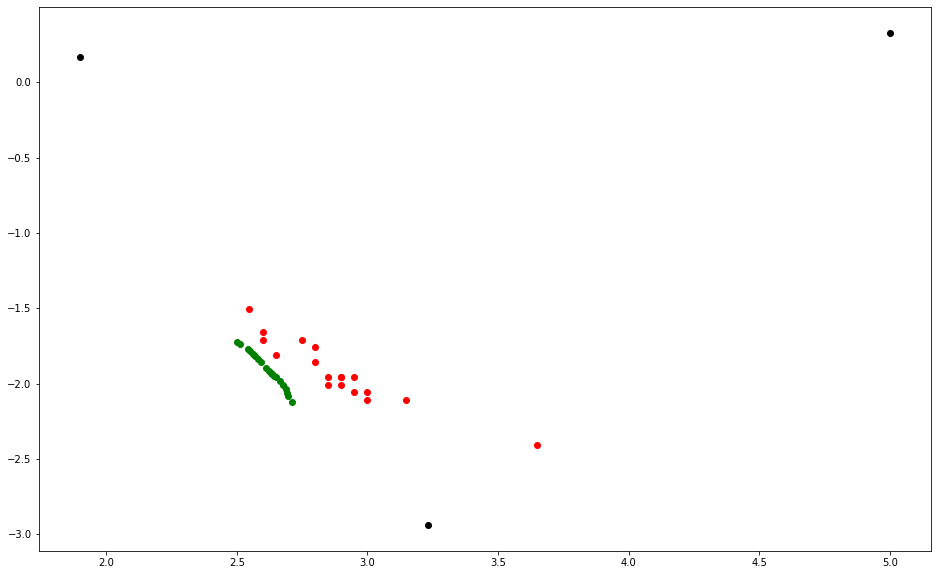

In [132]:
plt.figure(figsize=(16,10))
plt.scatter(pos_predict_filter[:,0],pos_predict_filter[:,1],c='red')
plt.scatter(pos_test[:,0],pos_test[:,1],c='green')
plt.scatter([1.90,5.00,3.23],[0.17,0.33,-2.94],c='black')
plt.show()

In [264]:
p_x_init,p_y_init,p_z_init = pos_predict[0]
time_period = df_merge_1.iloc[12880,3]-df_merge_1.iloc[11720,3]
v_x = (df_merge_1.iloc[12880,5]-df_merge_1.iloc[11720,5])/time_period
v_y = (df_merge_1.iloc[12880,6]-df_merge_1.iloc[11720,6])/time_period
v_z = 0
alpha = math.radians(df_merge_1.iloc[13074,14])
beta = math.radians(df_merge_1.iloc[13074,15])
gama = math.radians(df_merge_1.iloc[13074,16])
a_x = df_merge_1.iloc[13074,11]*0.01
a_y = df_merge_1.iloc[13074,12]*0.01
a_z = df_merge_1.iloc[13074,13]*0.01

trans = np.array([
[1,0,0,time_period,0,0],
[0,1,0,0,time_period,0],
[0,0,1,0,0,time_period],
[0,0,0,1,0,0],
[0,0,0,0,1,0],
[0,0,0,0,0,1]])

D = np.array([
    [0.5*time_period*time_period,0,0],
    [0,0.5*time_period*time_period,0],
    [0,0,0.5*time_period*time_period],
    [time_period,0,0],
    [0,time_period,0],
    [0,0,time_period]])

Rot = np.array([
    [cos(alpha)*cos(gama),sin(gama)*cos(alpha)*sin(alpha)-sin(alpha)*cos(beta),cos(alpha)*sin(gama)*cos(beta)+sin(alpha)*sin(beta)],
    [sin(alpha)*cos(gama),sin(alpha)*sin(beta)*sin(gama)+cos(alpha)*cos(beta),sin(alpha)*cos(beta)*cos(gama)-cos(alpha)*sin(beta)],
    [-sin(gama),cos(gama)*sin(beta),cos(gama)*cos(beta)]])

x_pre = np.array([p_x_init,p_y_init,p_z_init,v_x,v_y,0])
U = np.array([a_x,a_y,0])


x_cur = np.dot(trans,x_pre.T)+np.dot(np.dot(D,Rot),U.T)   

In [366]:
def dead_reckning(pos,acc,vol,time_period,eular):
    v_x = vol[0]
    v_y = vol[1]
    v_z = vol[2]
    alpha = eular[0]
    beta = eular[1]
    gama = eular[2]
    a_x = acc[0]
    a_y = acc[1]
    a_z = acc[2]
    
    trans = np.array([
    [1,0,0,time_period,0,0],
    [0,1,0,0,time_period,0],
    [0,0,1,0,0,time_period],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1]])
    
    D = np.array([
    [0.5*time_period*time_period,0,0],
    [0,0.5*time_period*time_period,0],
    [0,0,0.5*time_period*time_period],
    [time_period,0,0],
    [0,time_period,0],
    [0,0,time_period]])
    
    Rot = np.array([
    [cos(alpha)*cos(gama),sin(gama)*cos(alpha)*sin(alpha)-sin(alpha)*cos(beta),cos(alpha)*sin(gama)*cos(beta)+sin(alpha)*sin(beta)],
    [sin(alpha)*cos(gama),sin(alpha)*sin(beta)*sin(gama)+cos(alpha)*cos(beta),sin(alpha)*cos(beta)*cos(gama)-cos(alpha)*sin(beta)],
    [-sin(gama),cos(gama)*sin(beta),cos(gama)*cos(beta)]])
    
    x_pre = np.array([pos[0],pos[1],pos[2],v_x,v_y,v_z])
    U = [a_x,a_y,a_z]
    
    x_cur = np.dot(trans,x_pre)+np.dot(np.dot(D,Rot),U) 
    return x_cur[:3],x_cur[3:]   

In [355]:
def predict_reck(index_,pos,vol):
    index = model1_t1[index_]
    acc = (df_merge_1.iloc[index,11]*0.01,df_merge_1.iloc[index,12]*0.01,df_merge_1.iloc[index,13]*0.01)
    time_period = df_merge_1.iloc[index,3]-df_merge_1.iloc[model1_t1[index_-1],3]
    eular = (df_merge_1.iloc[index,14],df_merge_1.iloc[index,15],df_merge_1.iloc[index,16])
    pos_,vol_ = dead_reckning(pos,acc,vol,time_period,eular)
    return pos_,vol_

In [367]:
from queue import Queue

pos_queue = Queue()
vol_queue = Queue()
pos_queue.put(pos_init)
vol_queue.put(vol_init)
result = []
for i in [101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116]:
    pos = pos_queue.get()
    vol = vol_queue.get()
    pos_tem,vol_tem = predict_reck(i,pos,vol)
    result.append(pos)
    pos_queue.put(pos_tem)
    vol_queue.put(vol_tem)

In [369]:
mag_test = [get_mag(df_merge_1,x) for x in model1_t1[100:200]]
pos_test = [(df_merge_1.iloc[x,5],df_merge_1.iloc[x,6],df_merge_1.iloc[x,7]) for x in model1_t1[100:200]]

In [370]:
pos_predict = []
for i in range(len(mag_test)):
    pos_predict.append(predict_phy(mag_test[i][0],mag_test[i][1],mag_test[i][2]))

In [372]:
pos_init = pos_predict[0]

In [375]:
time_period_init = df_merge_1.iloc[model1_t1[100],3]-df_merge_1.iloc[1000,3]

In [382]:
v_x_init = (df_merge_1.iloc[model1_t1[100],5]-df_merge_1.iloc[1000,5])/time_period_init
v_y_init = (df_merge_1.iloc[model1_t1[100],6]-df_merge_1.iloc[1000,6])/time_period_init
v_z_init = 0
v_init = (v_x_init,v_y_init,v_z_init)

In [435]:
def predict_reck(index_end,pos,vol):
    
    acc = (df_merge_1.iloc[model1_t1[index_end],11]*0.01,df_merge_1.iloc[model1_t1[index_end],12]*0.01,df_merge_1.iloc[model1_t1[index_end],13]*0.01)
    time_period = df_merge_1.iloc[model1_t1[index_end],3]-df_merge_1.iloc[model1_t1[index_end]-1,3]
    eular = (df_merge_1.iloc[model1_t1[index_end],14],df_merge_1.iloc[model1_t1[index_end],15],df_merge_1.iloc[model1_t1[index_end],16])
    pos_,vol_ = dead_reckning(pos,acc,vol,time_period,eular)

    return pos_,vol_

In [415]:
predict_reck(101,pos_init,v_init)

(array([ 2.97296499, -2.08199174,  0.73599996]),
 array([-0.05794445,  0.01366783, -0.00011783]))

In [520]:
from queue import Queue

pos_queue = Queue()
vol_queue = Queue()
pos_queue.put(np.array(pos_init))
vol_queue.put(np.array(v_init))
result = []
for i in range(50):
    pos = pos_queue.get()
    vol = vol_queue.get()
    pos_tem,vol_tem = predict_reck(i,pos,vol)
    if pos_predict[i-100][0]!=0:
        #pos_tem = 0.8*pos_tem+0.2*pos_predict[i-100]
        pos_tem = 0.7*np.asarray(pos_tem)+0.3*np.asarray(pos_predict[i-100])
    result.append(pos)
    pos_queue.put(pos_tem)
    vol_queue.put(vol_tem)

In [521]:
result = np.array(result)


In [522]:
pos_test = np.array(pos_test)

In [523]:
pos_predict = np.array(pos_predict)

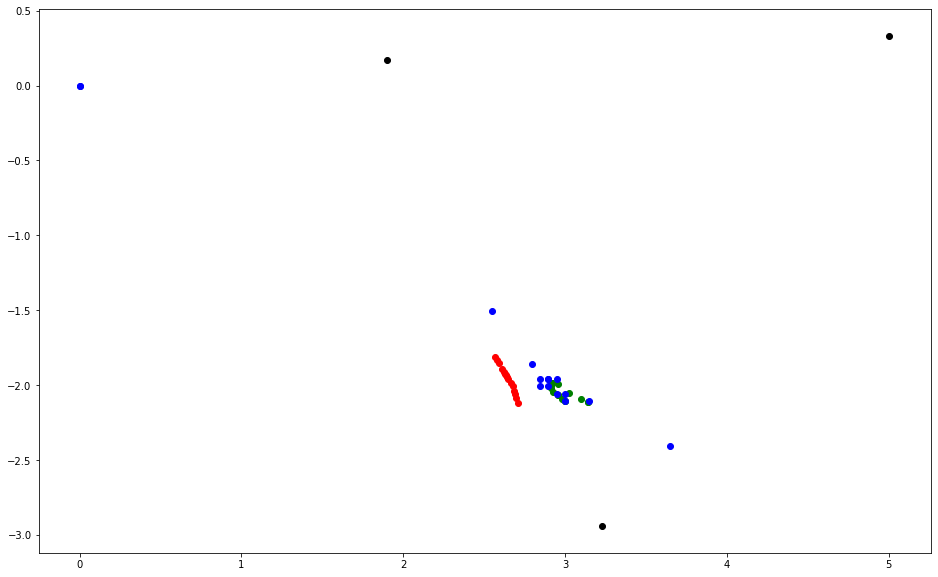

In [524]:
plt.figure(figsize=(16,10))
plt.scatter(pos_test[:15,0],pos_test[:15,1],c='red')
plt.scatter(result[:15,0],result[:15,1],c='green')
plt.scatter(pos_predict[:15,0],pos_predict[:15,1],c='blue')
plt.scatter([1.90,5.00,3.23],[0.17,0.33,-2.94],c='black')
plt.show()

In [494]:
time_period_1 = df_merge_1.iloc[4000,3]-df_merge_1.iloc[3000,3]

In [505]:
v_x = (df_merge_1.iloc[4000,5]-df_merge_1.iloc[3000,5])/time_period
v_y = (df_merge_1.iloc[4000,6]-df_merge_1.iloc[3000,6])/time_period
v_z = 0

In [506]:
v_x

0.0528078060244857

In [507]:
v_y

-0.10854937905033804

In [509]:
df_merge_1.iloc[3000:3010,:]

,R_x,R_y,R_z,Time_Stamp,Magnitude,p_x,p_y,p_z,d_t1,d_t2,d_t3,a_x,a_y,a_z,alpha,beta,gama
Serial_Num,,,,,,,,,,,,,,,,,
3000,4799205,4886440,5014353,1.577189e+09,8.488427e+06,3.4918,-2.2732,0.736,2.959235,3.050464,0.875887,9.65,-0.33,-0.23,81.63,87.5,178.25
3001,4304480,4600214,4115159,1.577189e+09,7.524962e+06,3.4918,-2.2732,0.736,2.959235,3.050464,0.875887,9.65,-0.33,-0.23,81.63,87.5,178.25
3002,4037455,4529339,3705875,1.577189e+09,7.109815e+06,3.4918,-2.2732,0.736,2.959235,3.050464,0.875887,9.65,-0.33,-0.23,81.63,87.5,178.25
3003,5463448,5298428,4646521,1.577189e+09,8.916993e+06,3.4918,-2.2732,0.736,2.959235,3.050464,0.875887,9.65,-0.33,-0.23,81.63,87.5,178.25
3004,5658245,5460156,5027630,1.577189e+09,9.333065e+06,3.4918,-2.2732,0.736,2.959235,3.050464,0.875887,9.65,-0.33,-0.23,81.63,87.5,178.25
3005,5704528,5502748,5080048,1.577189e+09,9.414285e+06,3.4914,-2.2731,0.736,2.958937,3.050577,0.875843,9.65,-0.33,-0.23,81.63,87.5,178.25
3006,5720131,5475933,5095703,1.577189e+09,9.416577e+06,3.4914,-2.2731,0.736,2.958937,3.050577,0.875843,9.65,-0.33,-0.23,81.63,87.5,178.25
3007,5724546,5510905,5103468,1.577189e+09,9.443828e+06,3.4914,-2.2731,0.736,2.958937,3.050577,0.875843,9.65,-0.33,-0.23,81.63,87.5,178.25
3008,5707500,5445535,5094986,1.577189e+09,9.390862e+06,3.4914,-2.2731,0.736,2.958937,3.050577,0.875843,9.65,-0.33,-0.23,81.63,87.5,178.25
